In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from xgboost import XGBRegressor

In [32]:
df = pd.read_csv("/kaggle/input/datathon2025/train.csv")
original_df = df
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [33]:
df.drop(["Id"], axis=1, inplace=True)

# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)  # Fill numeric with median
df.fillna("Unknown", inplace=True)  # Fill categorical with "Unknown"

In [34]:
label_encoders = {}
cat_cols = df.select_dtypes(include=["object"]).columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [35]:
X = df.drop(["SalePrice"], axis=1)
y = df["SalePrice"]

# Train XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [43]:
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
top_5_features = feature_importance.nlargest(5).index.tolist()
print("Top 5 Features for Clustering:", top_5_features)


Top 5 Features for Clustering: ['OverallQual', 'GarageCars', 'GrLivArea', 'KitchenAbvGr', 'BsmtQual']


In [44]:
scaler = StandardScaler()
X_top5_scaled = scaler.fit_transform(df[top_5_features])

In [45]:
inertia = []
sil_scores = []
k_range = range(2, 10)

In [46]:
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_top5_scaled)
    inertia.append(kmeans.inertia_)  # Sum of squared distances
    sil_scores.append(silhouette_score(X_top5_scaled, kmeans.labels_))  # Silhouette score


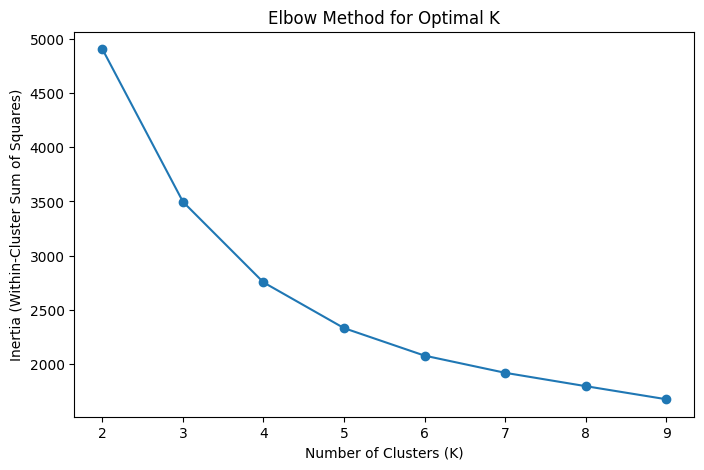

In [47]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker="o", linestyle="-")
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.show()

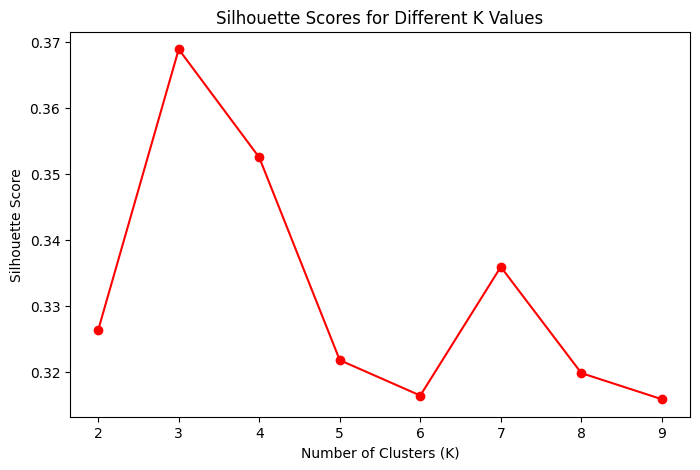

In [48]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, sil_scores, marker="o", linestyle="-", color='red')
plt.title("Silhouette Scores for Different K Values")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()

In [49]:
best_k = 4  # Choose based on elbow & silhouette score
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(X_top5_scaled)


In [53]:
neighborhood_clusters = df.groupby("Cluster")["Neighborhood"].unique()
print("\nNeighborhoods in Each Cluster:")
for cluster, neighborhoods in neighborhood_clusters.items():
    print(f"Cluster {cluster}: {list(neighborhoods)}")

# **Step 5: Analyze Price Trends per Cluster**
cluster_prices = df.groupby("Cluster")["SalePrice"].mean().sort_values()
print("\nAverage House Prices per Cluster:")
print(cluster_prices)


Neighborhoods in Each Cluster:
Cluster 0: [15, 21, 16, 5, 11, 24, 22, 20, 23, 17, 6, 12, 0, 7, 8, 14, 4]
Cluster 1: [19, 12, 20, 9, 10, 3, 5, 23, 17, 11, 6, 7, 4, 2, 18, 8, 14]
Cluster 2: [17, 3, 19, 7, 20, 11, 12, 6, 18, 9, 14]
Cluster 3: [5, 24, 6, 11, 14, 3, 16, 12, 21, 8, 20, 17, 4, 15, 9, 13, 19, 7, 23, 22, 0, 18, 1, 10]

Average House Prices per Cluster:
Cluster
1    124349.046263
2    130451.492537
3    196071.504518
0    331311.694611
Name: SalePrice, dtype: float64


In [50]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(X_top5_scaled)
df["PCA1"] = df_pca[:, 0]
df["PCA2"] = df_pca[:, 1]


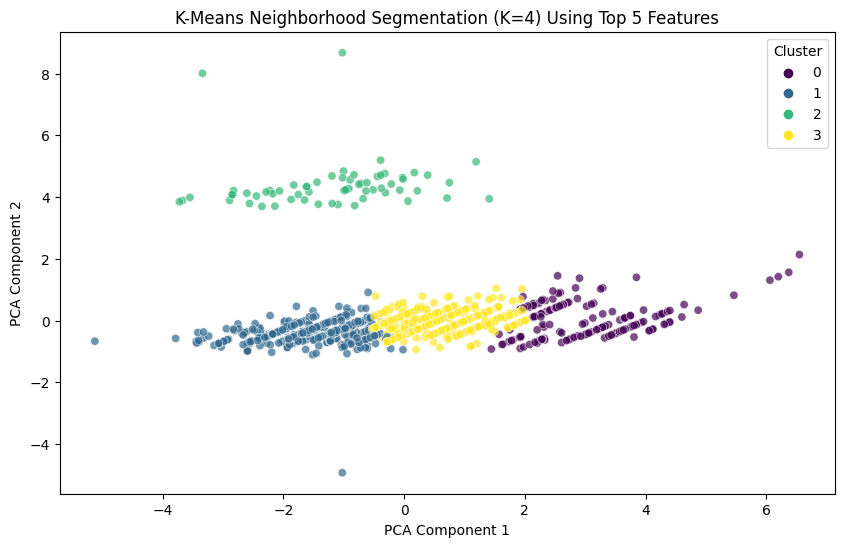

In [51]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df["PCA1"], y=df["PCA2"], hue=df["Cluster"], palette="viridis", alpha=0.7)
plt.title(f"K-Means Neighborhood Segmentation (K={best_k}) Using Top 5 Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

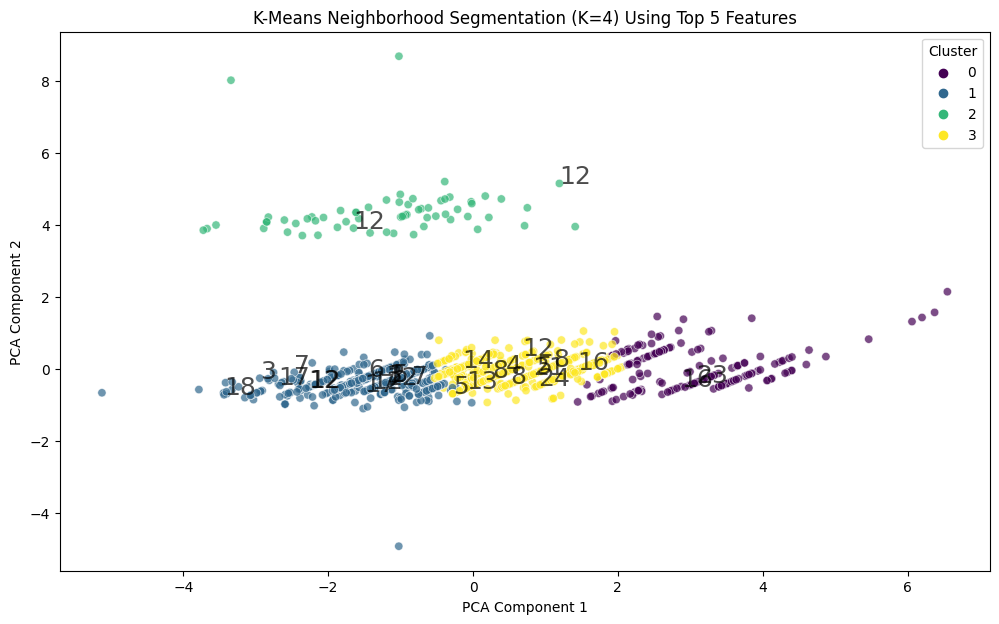

In [59]:
plt.figure(figsize=(12, 7))
scatter = sns.scatterplot(x=df["PCA1"], y=df["PCA2"], hue=df["Cluster"], palette="viridis", alpha=0.7)
plt.title(f"K-Means Neighborhood Segmentation (K={best_k}) Using Top 5 Features")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Add text labels for major neighborhoods
for i in range(df.shape[0]):
    if i % 50 == 0:  # Avoid overcrowding
        plt.text(df["PCA1"][i], df["PCA2"][i], df["Neighborhood"][i], fontsize=18, alpha=0.7)

plt.legend(title="Cluster")
plt.show()